<div class="markdown-google-sans">
  <center>
  <h1>Devices and circuits for Artificial Intelligence</h1>
  <h2>-- 540438 - Maurizio La Rosa --</h2>
  <h2>Final exam project</h2>
  </center>
</div>

In this notebook I introduce the project for the final exam of the course <i>Devices and circuits for artificial intelligence</i> from the Data Analysis degree of the University of Messina. The project consists in building a machine learning model for image classification.

The dataset to be used is hosted at <a href = 'https://www.kaggle.com/'>kaggle</a>, and is called <a href = 'https://www.kaggle.com/datasets/gpiosenka/100-bird-species'>BIRDS 525 SPECIES- IMAGE CLASSIFICATION</a>. The dataset currently contains images from 525 bird species to be classified by the model. I downloaded the dataset on April, 17th, 2023, and that version contains 515 bird species.

It is useful to note that images in the dataset should have all the exact same shape (224, 224, 3), while I found that all images of the 'PLUSH CRESTED JAY' species and one image from the 'DON'T REMEMBER THE SPECIES, FILL INFO WITH FUTURE COMMIT' species have variable shapes. Hence, in my code, I check for images' shapes and remove images that don't match the common shape. This is important because imported images have the shape of 3D Numpy (np, when imported) arrays and I need to transform the list of images into a 4D Numpy array. The function np.array() can do it automatically when fed a list of 3D Numpy arrays, but images must have all the same shape.

The following cell is for importing necessary modules in the file used for describing the data, the model and the results.
I previously uploaded data for bird species classification on Colab, in the <i>content/kaggle_data</i> folder.

In [1]:
##########################################
### allow importing from Google Drive  ###
###  after uploading the needed files  ###
##########################################
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/da_dcAI_project')

##########################################
### unzip reshaped dataset from Google ###
###  Drive to colab's content folder   ###
##########################################
!unzip '/content/drive/MyDrive/Colab Notebooks/da_dcAI_project/reshaped_dataset.zip'

##########################################
### import necessary or useful modules ###
##########################################
import os
import numpy as np
#import tensorflow as tf
from    matplotlib                import pyplot as plt
from    tensorflow.keras.utils    import to_categorical
from    keras.preprocessing.image import ImageDataGenerator
from    sklearn.metrics           import classification_report, confusion_matrix
from    a_selectRandomFolders     import selectRandomFolders
from    b_viewClasses             import viewRandomClasses, viewRandomClass
from    c_selectData              import selectData, classesToInt, countLabels
from    d_tl_model_DenseNet       import seqModel
from    e_plotConfusionMatrix     import plotCM

Streaming output truncated to the last 5000 lines.
  inflating: reshaped/train/WILD TURKEY/055.jpg  
  inflating: reshaped/train/WILD TURKEY/056.jpg  
  inflating: reshaped/train/WILD TURKEY/057.jpg  
  inflating: reshaped/train/WILD TURKEY/058.jpg  
  inflating: reshaped/train/WILD TURKEY/059.jpg  
  inflating: reshaped/train/WILD TURKEY/060.jpg  
  inflating: reshaped/train/WILD TURKEY/061.jpg  
  inflating: reshaped/train/WILD TURKEY/062.jpg  
  inflating: reshaped/train/WILD TURKEY/063.jpg  
  inflating: reshaped/train/WILD TURKEY/064.jpg  
  inflating: reshaped/train/WILD TURKEY/065.jpg  
  inflating: reshaped/train/WILD TURKEY/066.jpg  
  inflating: reshaped/train/WILD TURKEY/067.jpg  
  inflating: reshaped/train/WILD TURKEY/068.jpg  
  inflating: reshaped/train/WILD TURKEY/069.jpg  
  inflating: reshaped/train/WILD TURKEY/070.jpg  
  inflating: reshaped/train/WILD TURKEY/071.jpg  
  inflating: reshaped/train/WILD TURKEY/072.jpg  
  inflating: reshaped/train/WILD TURKEY/073.jpg  

<div class="markdown-google-sans">
  <h2>Retrieve data folders</h2>
</div>

The following code cell is used for retrieving the system folders where the data are located.

In [2]:
### 1) set path to the directory of the dataset (this is the targetFolder)
###    and show how many bird classes there are in the path and their names
trainPathWin = 'C:/Users/mzlarosa/OneDrive - unime.it/Learning/CdL Informatica/Anno II - Devices and circuits for artificial intelligence/project/dataset/archive/train'
testPathWin = 'C:/Users/mzlarosa/OneDrive - unime.it/Learning/CdL Informatica/Anno II - Devices and circuits for artificial intelligence/project/dataset/archive/test'
validPathWin = 'C:/Users/mzlarosa/OneDrive - unime.it/Learning/CdL Informatica/Anno II - Devices and circuits for artificial intelligence/project/dataset/archive/valid'
trainPathMac = '/Users/mau/OneDrive - unime.it/Learning/CdL Informatica/Anno II - Devices and circuits for artificial intelligence/project/dataset/archive/train'
testPathMac = '/Users/mau/OneDrive - unime.it/Learning/CdL Informatica/Anno II - Devices and circuits for artificial intelligence/project/dataset/archive/test'
validPathMac = '/Users/mau/OneDrive - unime.it/Learning/CdL Informatica/Anno II - Devices and circuits for artificial intelligence/project/dataset/archive/valid'
trainPath = '/content/reshaped/train'
testPath = '/content/reshaped/test'
validPath = '/content/reshaped/valid'
classes = os.listdir(trainPath)
if '.DS_Store' in classes:
    classes.remove('.DS_Store')
nOfClasses = len(classes)
print('\nThere are', nOfClasses, 'classes in the dataset.\n' +
      '\nHere is a list of the first 50 classes:')
print(classes[0 : 50], end = '')
print('[...]')


There are 515 classes in the dataset.

Here is a list of the first 50 classes:
['BLACK-CAPPED CHICKADEE', 'BLONDE CRESTED WOODPECKER', 'WHITE BROWED CRAKE', 'AMERICAN GOLDFINCH', 'LIMPKIN', 'APAPANE', 'BLACKBURNIAM WARBLER', 'NORTHERN FLICKER', 'PAINTED BUNTING', 'AUSTRALASIAN FIGBIRD', 'ANDEAN SISKIN', 'EMPEROR PENGUIN', 'TRICOLORED BLACKBIRD', 'RUBY THROATED HUMMINGBIRD', 'PHILIPPINE EAGLE', 'MALACHITE KINGFISHER', 'GYRFALCON', 'MILITARY MACAW', 'GOLD WING WARBLER', 'VARIED THRUSH', 'GROVED BILLED ANI', 'EASTERN BLUEBONNET', 'MALLARD DUCK', 'NORTHERN MOCKINGBIRD', 'HOUSE SPARROW', 'OYSTER CATCHER', 'CAPPED HERON', 'ASIAN CRESTED IBIS', 'COMMON POORWILL', 'OCELLATED TURKEY', 'IVORY BILLED ARACARI', 'NORTHERN RED BISHOP', 'QUETZAL', 'TROPICAL KINGBIRD', 'CRIMSON SUNBIRD', 'AFRICAN CROWNED CRANE', 'GREAT TINAMOU', 'GREAT KISKADEE', 'FRILL BACK PIGEON', 'GILA WOODPECKER', 'HYACINTH MACAW', 'HARLEQUIN DUCK', 'GREY PLOVER', 'LILAC ROLLER', 'FASCIATED WREN', 'BROWN CREPPER', 'SATYR TRAGOPA

<div class="markdown-google-sans">

## <strong>Introduce the data</strong>
</div>

The number of available pictures varies with the class. <br>
I select a random sample of 15 bird species from the train data and show how many images are available for each sampled species.

In [ ]:
### 2) select a random sample of n (15) subfolders from the targetFolder
###    and show their content (subfolders represent bird classes)
###    modules: os, random, selectRandomFolders
targetClasses = selectRandomFolders(trainPath, 15)

There are 0 folders and 139 image files in /content/reshaped/train/NORTHERN FLICKER
There are 0 folders and 160 image files in /content/reshaped/train/BORNEAN LEAFBIRD
There are 0 folders and 173 image files in /content/reshaped/train/HORNED LARK
There are 0 folders and 139 image files in /content/reshaped/train/TRICOLORED BLACKBIRD
There are 0 folders and 165 image files in /content/reshaped/train/TOWNSENDS WARBLER
There are 0 folders and 175 image files in /content/reshaped/train/HARPY EAGLE
There are 0 folders and 168 image files in /content/reshaped/train/BLACK-THROATED SPARROW
There are 0 folders and 175 image files in /content/reshaped/train/KILLDEAR
There are 0 folders and 136 image files in /content/reshaped/train/BARRED PUFFBIRD
There are 0 folders and 187 image files in /content/reshaped/train/AUCKLAND SHAQ
There are 0 folders and 193 image files in /content/reshaped/train/VARIED THRUSH
There are 0 folders and 135 image files in /content/reshaped/train/GOLDEN CHLOROPHONIA
The

<div class="markdown-google-sans">

## <strong>Plot pictures from sample species</strong>
</div>

<div class="markdown-google-sans">

<h3>Plot one picture from 15 randomly selected species</h3>
</div>

Then I draw a random picture from each class and show their shape and size. A picture's shape shows tipically three dimensions. The first two dimensions build a 2D matrix of n rows by m columns. The number of rows represents the image height in pixels, while the number of columns represents the image width in pixels. So each matrix coordinate point represents the intensity value of a single pixel. The third dimension refers to the number of color planes (or channels). There is one plane (2D matrix) for each RGB color, so the value of the third dimension is 3. A picture's size shows its total number of pixels, which results by multiplying the dimensions of the 2D matrices by themselves and by the number of color planes.

Class: NORTHERN FLICKER
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: BORNEAN LEAFBIRD
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: HORNED LARK
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: TRICOLORED BLACKBIRD
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: TOWNSENDS WARBLER
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: HARPY EAGLE
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: BLACK-THROATED SPARROW
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: KILLDEAR
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408 

Class: BARRED PUFFBIRD
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels)

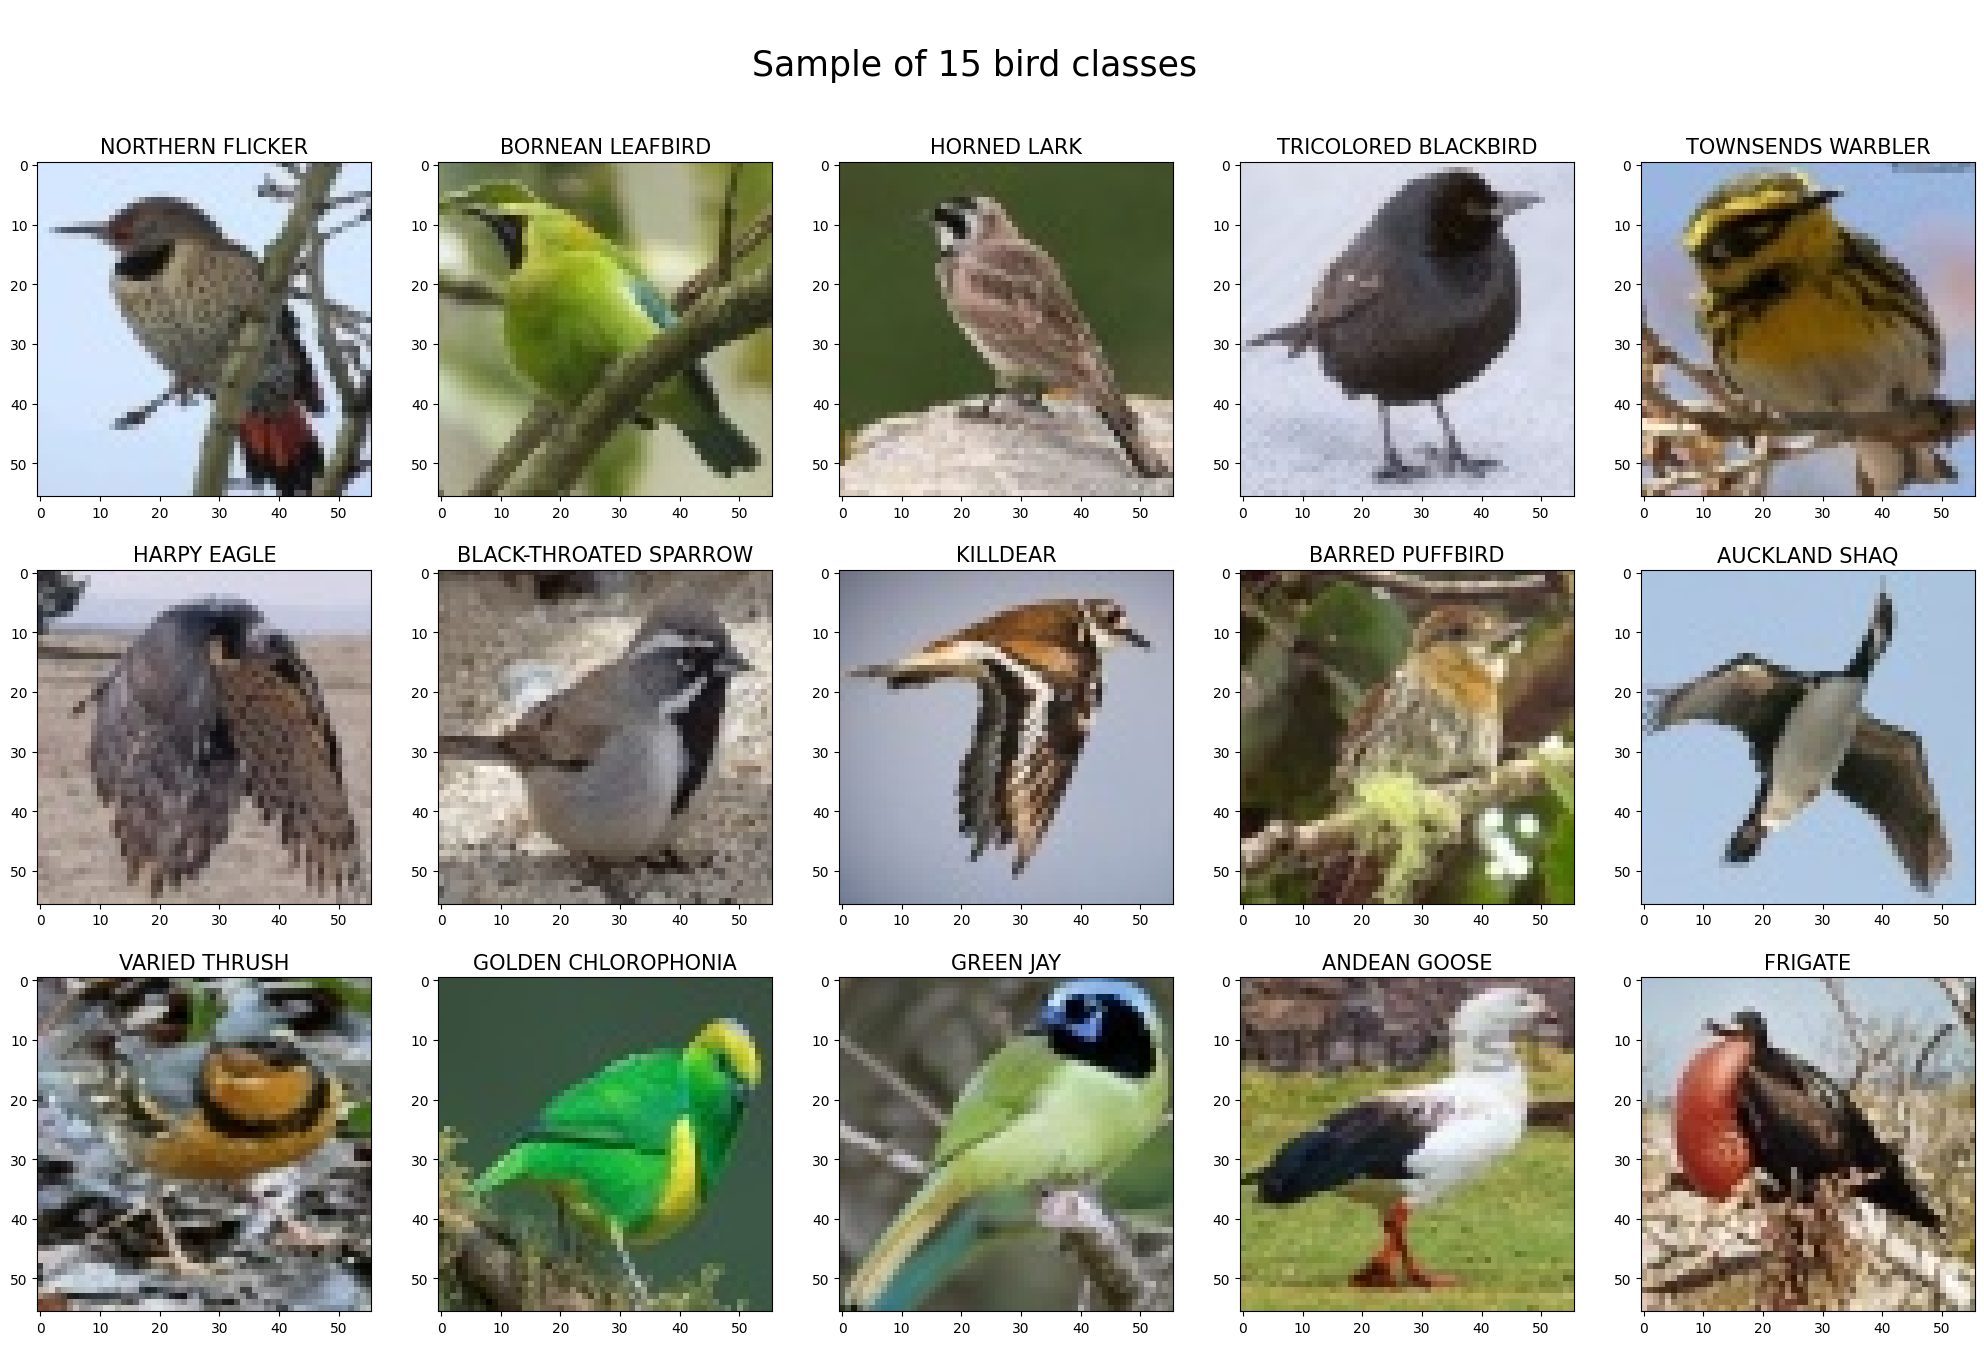

In [ ]:
### 3) plot one random image from each bird class
###    modules: b_viewClasses
randomClasses = viewRandomClasses(trainPath, targetClasses[0])
plt.show()

<div class="markdown-google-sans">

<h3>Plot 15 pictures from one of the previously selected random species</h3>
</div>

Finally, we print 15 random images from one of the previously chosen species and show their shape and size as before defined.

VARIED THRUSH
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, channels): (56, 56, 3)
Image size (number of pixels): 9408
Image shape (rows, columns, c

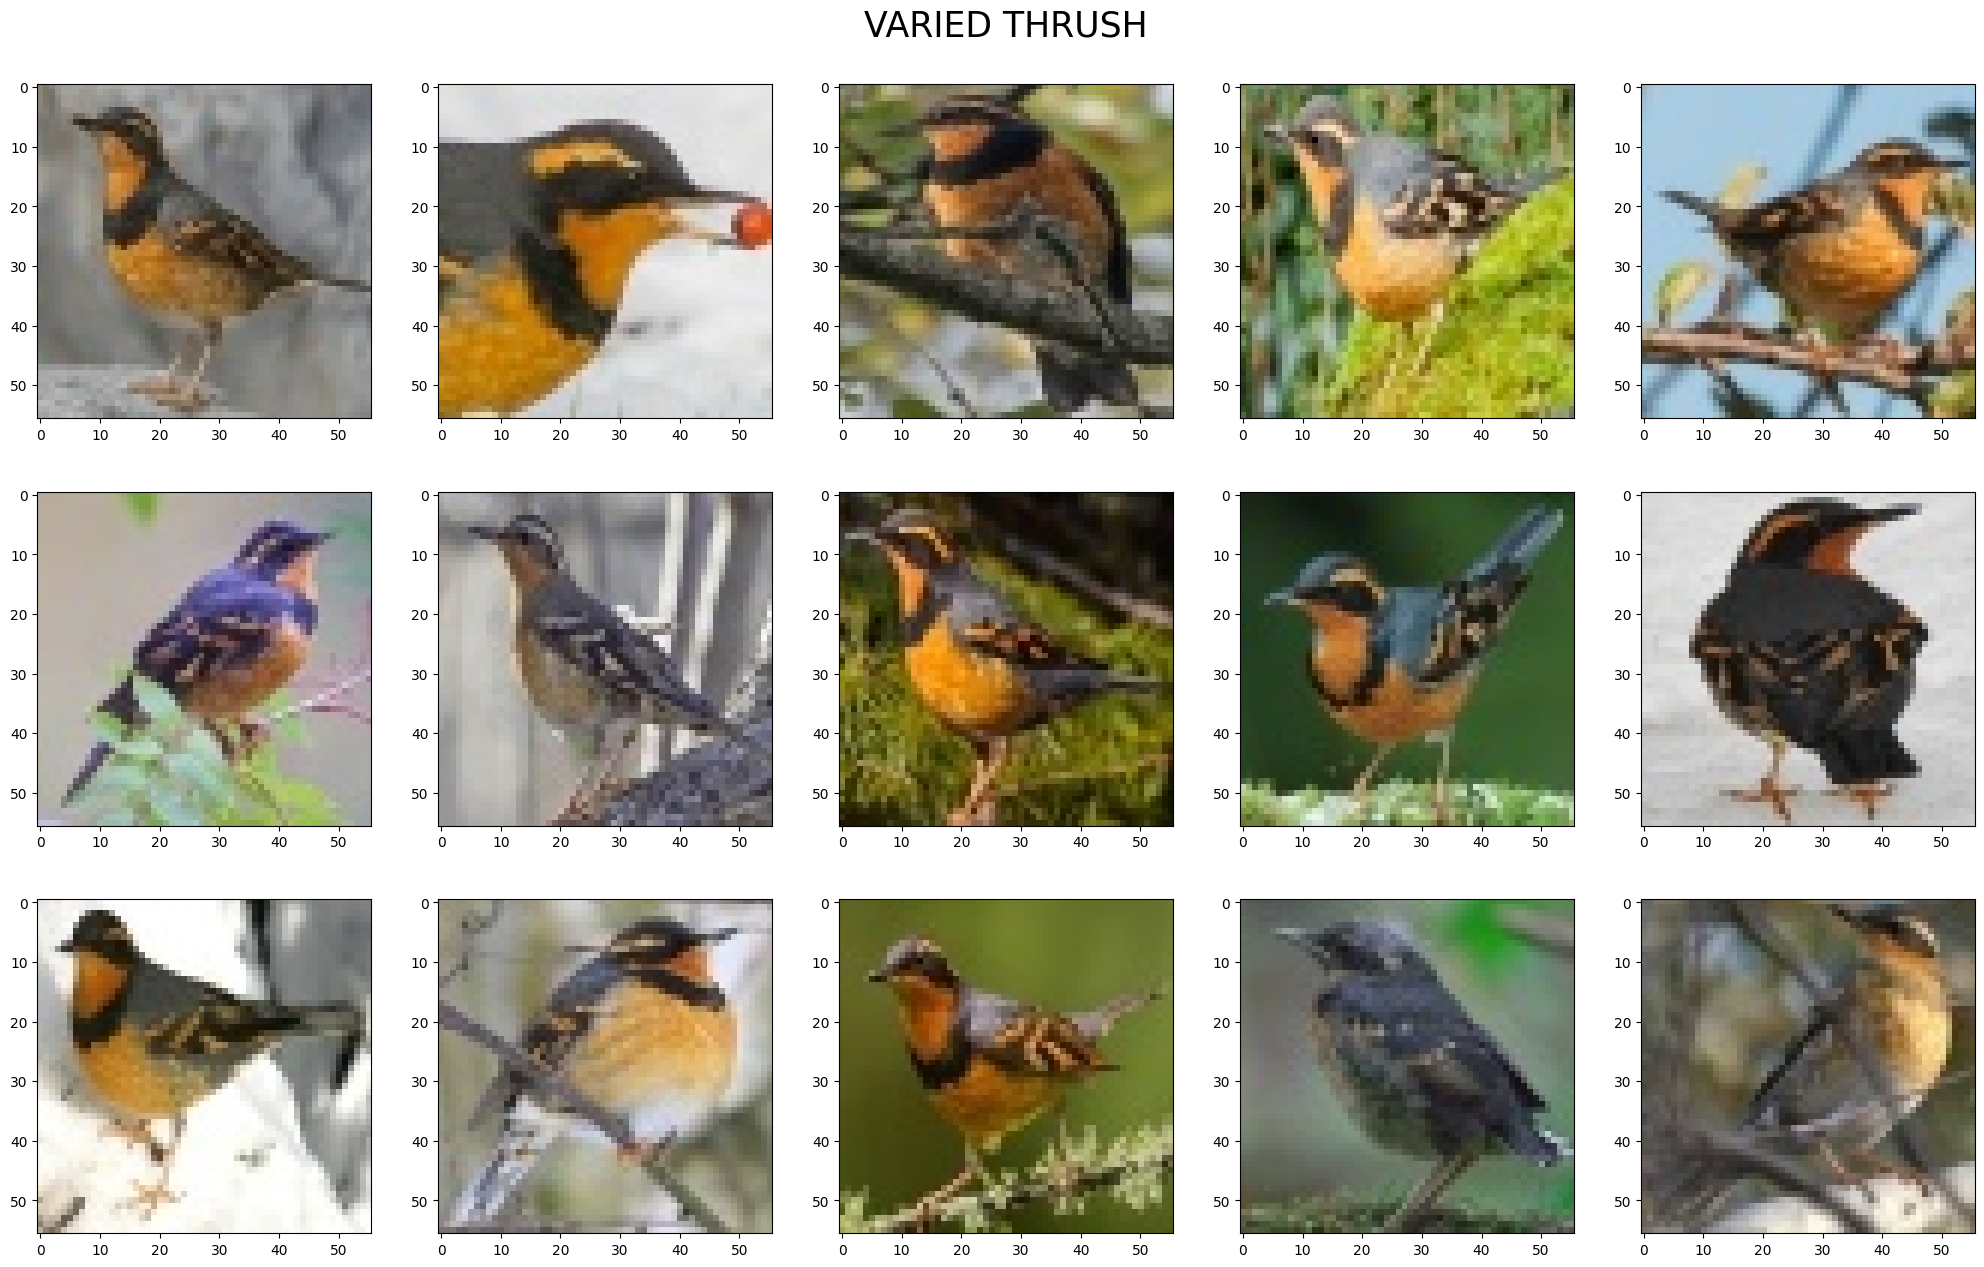


I conclude that, although there is a varying number of images for each bird class,
in our sample of 15 classes there is a minimum of 134 images, and a maximum of 193 images.



In [ ]:
### 4) plot 15 random images from one of the classes
###    modules: b_viewClasses
randomClass = viewRandomClass(trainPath, targetClasses[0])
plt.show()
print('\nI conclude that, although there is a varying number of images',
      'for each bird class,')
print('in our sample of 15 classes there is a minimum',
      'of', min(targetClasses[2]), 'images, and a maximum of',
      max(targetClasses[2]), 'images.\n')

<div class="markdown-google-sans">

## <strong>Data preparation</strong>
</div>

The following code allows me to load each image of the train and test sets into Python lists. The lists containing the images are then turned into numerical arrays, with 4 dimensions: the first one represents the number of images, while the other three represent the images' shape, which has been rendered homogeneous (56, 56, 3) by removing those not matching the common shape within the execution of the custom <i>selectData</i> function.

In [9]:
### 5) load the train, test and validation data and labels into memory
#trainData, trainClasses, testData, testClasses, validData, validClasses, cfClasses = selectData(destinationTrain, destinationTest, destinationValid)
trainData, trainClasses = selectData(trainPath)
testData, testClasses = selectData(testPath)
validData, validClasses = selectData(validPath)
#train, test and validation data lists into numpy arrays
npTrainData = np.array(trainData)
npTestData = np.array(testData)
npValidData = np.array(validData)

print('Our train data array has', npTrainData.ndim, 'dimensions, and a shape of',
      npTrainData.shape, 'for a total number of elements of', npTrainData.size, '.')
print('Our test data array has', npTestData.ndim, 'dimensions, and a shape of',
      npTestData.shape, 'for a total number of elements of', npTestData.size, '.')
print('Our validation data array is equivalent in number to the test data array. It has',
      npValidData.ndim, 'dimensions, and a shape of', npValidData.shape,
      'for a total number of elements of', npValidData.size, '.')

Our train data array has 4 dimensions, and a shape of (82724, 56, 56, 3) for a total number of elements of 778267392 .
Our test data array has 4 dimensions, and a shape of (2575, 56, 56, 3) for a total number of elements of 24225600 .
Our validation data array is equivalent in number to the test data array. It has 4 dimensions, and a shape of (2575, 56, 56, 3) for a total number of elements of 24225600 .


The data labels represent the bird species to which the images belong. They are first converted into 2D arrays and finally turned into categorical data: bird classes are substituted by numerical categories.<br>
Bird species should be homogeneous across train and test data, so I check if it's actually the case.

In [4]:
### 6) turn the train, test and validation labels into categorical arrays
# train labels
trainClasses = classesToInt(trainClasses)
npTrainClasses = np.array(trainClasses)
npTrainClasses = np.expand_dims(npTrainClasses, axis = 1) # add dimension to array
npTrainLabels = to_categorical(npTrainClasses)
# test labels
testClasses = classesToInt(testClasses)
npTestClasses = np.array(testClasses)
npTestClasses = np.expand_dims(npTestClasses, axis = 1) # add dimension to array
npTestLabels = to_categorical(npTestClasses)
# validation labels
validClasses = classesToInt(validClasses)
npValidClasses = np.array(validClasses)
npValidClasses = np.expand_dims(npValidClasses, axis = 1) # add dimension to array
npValidLabels = to_categorical(npValidClasses)

trainCount = countLabels(npTrainClasses) # count train labels
testCount = countLabels(npTestClasses)   # count test labels
validCount = countLabels(npValidClasses) # count validation labels
if trainCount == testCount and trainCount == validCount:
    print('There are', npTrainClasses.size, 'categories (it means that each image',
          'belongs to a category) for a set of', trainCount, 'categories.')
else:
    print('ERROR: train labels count, test labels count and validation labels count don\'t match.')

# free up memory
del trainData, testData, validData, trainClasses, testClasses, validClasses

There are 82724 categories (it means that each image belongs to a category) for a set of 515 categories.


<div class="markdown-google-sans">

## Data normalization
</div>

At this point I normalize the data by dividing them for the maximum value they can assume. In this way the data range from 0 to 1 and allow for better speed and prediction results.

In [5]:
### 7) normalize the data
npTrainData = np.array(npTrainData / npTrainData.max(), dtype = np.float16)
npTestData = np.array(npTestData / npTestData.max(), dtype = np.float16)
npValidData = np.array(npValidData / npValidData.max(), dtype = np.float16)

<div class="markdown-google-sans">

## Call the sequential model
</div>

I call the function executing the sequential model from the file d_sequentialModel. The function returns the model history, which is used to train the model and plot the loss function and the model accuracy.

In [6]:
### 8) call the sequential model
myModel, Y_pred = seqModel(npTrainData, npTrainLabels, npTestData, npTestLabels, npValidData, npValidLabels)

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 FC (Dense)                  (None, 515)               527875    
                                                                 
 Softmax (Activation)        (None, 515)               0         
                                                                 
Total params: 7565379 (28.86 MB)
Trainable params: 7481731 (28.54 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________
Epoch 1/10
1293/1293 [==============================] - 202s 100ms/step - loss: 4.8840 - accuracy: 0.1068 - val_loss: 3.2819 - val_accuracy: 0.2703
Epoch 2/10
1293/1293 [==============================] - 124s 96

I finally plot the loss function for the model and the model accuracy.

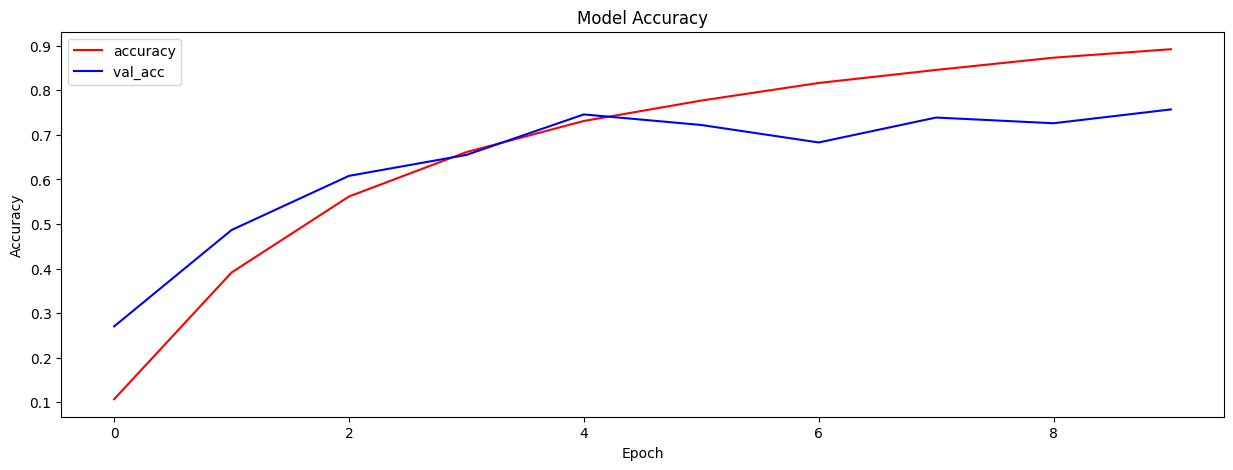

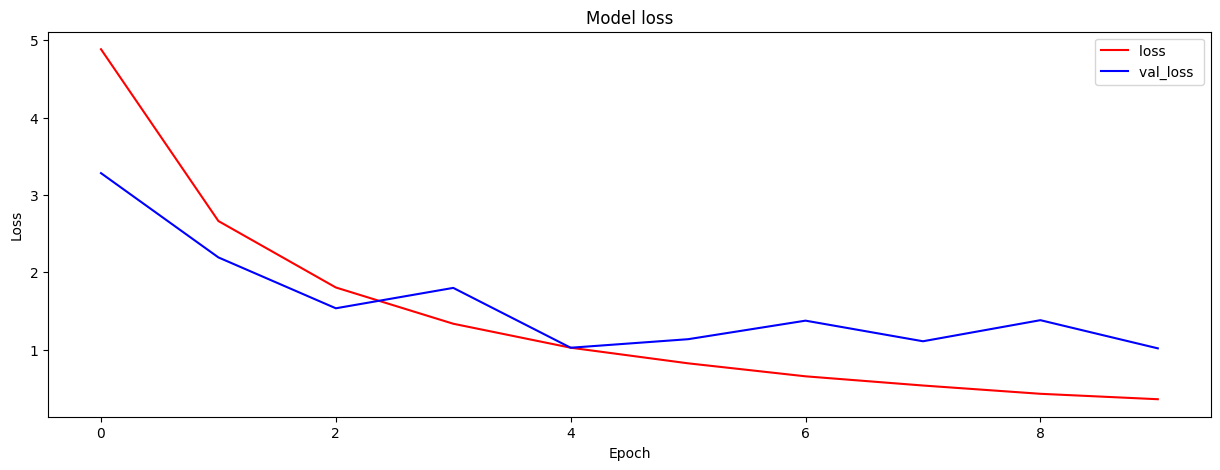

In [7]:
### 9) plot model accuracy and loss function
# accuracy
plt.figure(figsize=(15, 5))
plt.plot(myModel.history['accuracy'], 'r', label='accuracy')
plt.plot(myModel.history['val_accuracy'], 'b', label='val_acc ')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# loss
plt.figure(figsize=(15, 5))
plt.plot(myModel.history['loss'], 'r', label='loss ')
plt.plot(myModel.history['val_loss'], 'b', label='val_loss ')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

<div class="markdown-google-sans">

## Plot confusion matrix and classification report
</div>

I finally plot the confusion matrix and the classification report for a small sample of bird species.


Confusion Matrix (small sample)

[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]


Classification Report (small sample)

                               precision    recall  f1-score   support

       BLACK-CAPPED CHICKADEE       1.00      0.80      0.89         5
    BLONDE CRESTED WOODPECKER       0.71      1.00      0.83         5
           WHITE BROWED CRAKE       1.00      0.80      0.89         5
           AMERICAN GOLDFINCH       0.56      1.00      0.71         5
                      LIMPKIN       0.75      0.60      0.67         5
   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 600x600 with 0 Axes>

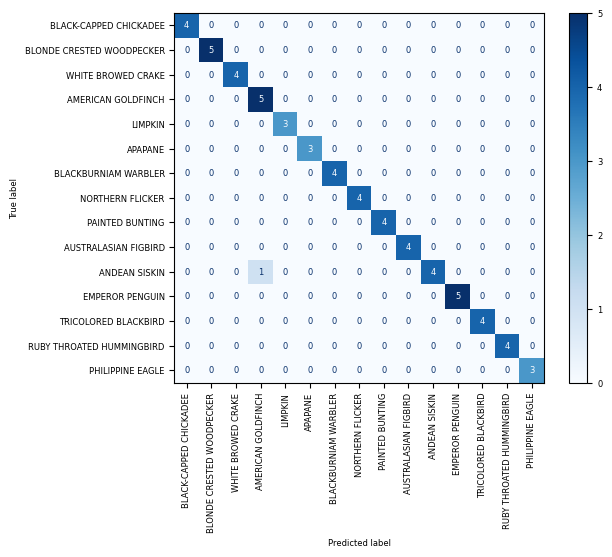

In [8]:
### 10) Confution Matrix and Classification Report
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(npTestClasses, y_pred)
thresh = cm.max() / 2.
tick_marks = np.arange(len(classes))
target_names = classes
print('\nConfusion Matrix (small sample)\n')
print(cm[0 : 15, 0 : 15])
plotCM(cm[0 : 15, 0 : 15], target_names[0 : 15])
print('\n\nClassification Report (small sample)\n')
class_report = classification_report(npTestClasses, y_pred, target_names = target_names)
print(class_report[0 : 1142], (' ' * 18) + '[...]\n') # print a few lines of the classification report